# Step1資料準備

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(x_train_10,y_train_10),(x_test_10,y_test_10)=cifar10.load_data()
y_train_10 = to_categorical(y_train_10)
y_test_10 = to_categorical(y_test_10)



In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.layers import Lambda, Dropout,Input, Activation, Dense, GlobalAveragePooling2D, Conv2D,Add, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback,LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import Model_mobilenet
from Model_mobilenet import MobileNet,MobileNet_drop
from image_noise import Rand_Augment

In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


### unlabel data讀取,標籤,篩選

In [4]:
##load 重新標籤完的dataset
x_train_student=np.load('x_train_student_3.npy')
y_train_student=np.load('y_train_student_3.npy')

### Student_model_3的訓練資料量總共有120,000張

In [5]:
x_train_student.shape

(120000, 32, 32, 3)

### Student_model_3 訓練

In [6]:
img_augment = Rand_Augment(Numbers=2, max_Magnitude=10)

def get_random_data(x_train_i, y_train_i, data_aug):
    x = array_to_img(x_train_i)

    if data_aug:

        seed_image = img_augment(x)
        seed_image = img_to_array(seed_image)

    else:
        seed_image = x_train_i

    seed_image = seed_image / 255

    return seed_image, y_train_i

def data_generator(x_train, y_train, batch_size, data_aug):
    '''data generator for fit_generator'''
    n = len(x_train)
    i = 0
    while True:
        image_data = []
        label_data = []
        for b in range(batch_size):
            if i==0:
                p = np.random.permutation(len(x_train))
                x_train = x_train[p]
                y_train = y_train[p]
            image, label = get_random_data(x_train[i], y_train[i], data_aug)
            image_data.append(image)
            label_data.append(label)
            i = (i+1) % n
        image_data = np.array(image_data)
        label_data = np.array(label_data)
        yield image_data, label_data

In [7]:
img_input=Input(shape=(32,32,3))
output = MobileNet_drop(img_input,dropout_set=0.1)
student_model_3 = Model(img_input,output)
student_model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 24)        672       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 16, 16, 24)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 24)        240       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 24)        0     

In [8]:
import os

In [9]:
log_dir = 'logs/softlabel/student1_2/'

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',\
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

student_model_3.compile(loss = "categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])

batch_size = 64
steps_per_epoch = x_train_student.shape[0] // batch_size
validation_steps = x_test_10.shape[0] // batch_size
history = student_model_3.fit_generator(data_generator(x_train_student, y_train_student, batch_size, data_aug = True),
                                      initial_epoch=0,
                                      epochs=50,
                                      steps_per_epoch = steps_per_epoch,
                                      validation_data = data_generator(x_test_10, y_test_10, batch_size, data_aug = False),
                                      validation_steps = validation_steps,
                                      callbacks=[checkpoint, reduce_lr, early_stopping])




Epoch 1/50
1875/1875 [==============================] - 229s 122ms/step - loss: 2.0242 - accuracy: 0.2687 - val_loss: 2.2525 - val_accuracy: 0.3357
Epoch 2/50
1875/1875 [==============================] - 228s 121ms/step - loss: 1.7770 - accuracy: 0.3825 - val_loss: 1.6041 - val_accuracy: 0.4436
Epoch 3/50
1875/1875 [==============================] - 230s 123ms/step - loss: 1.6270 - accuracy: 0.4585 - val_loss: 1.3215 - val_accuracy: 0.5142
Epoch 4/50
1875/1875 [==============================] - 222s 119ms/step - loss: 1.5181 - accuracy: 0.5127 - val_loss: 1.1767 - val_accuracy: 0.5843
Epoch 5/50
1875/1875 [==============================] - 227s 121ms/step - loss: 1.4261 - accuracy: 0.5576 - val_loss: 1.1131 - val_accuracy: 0.6051
Epoch 6/50
1875/1875 [==============================] - 233s 124ms/step - loss: 1.3570 - accuracy: 0.5931 - val_loss: 1.0219 - val_accuracy: 0.6362
Epoch 7/50
1875/1875 [==============================] - 228s 121ms/step - loss: 1.3059 - accuracy: 0.6182 - val_

In [10]:
student_model_3.save('student_model_3_624.h5')
history.history.keys()
student_3 = pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))
student_3.to_csv('E:/NCHU_PHD/10902sml/report2/final_624/student_3.CSV')



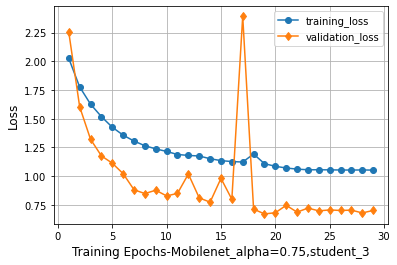

In [11]:
from matplotlib import pyplot as plt
plt.plot(student_3['loss'], marker='o', label='training_loss')
plt.plot(student_3['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_3', fontsize=12)
plt.grid()
plt.legend()

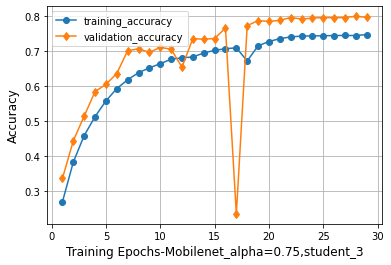

In [12]:
plt.plot(student_3['accuracy'], marker='o', label='training_accuracy')
plt.plot(student_3['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_3', fontsize=12)
plt.grid()
plt.legend()

In [13]:
###test
img_path = "E:/NCHU_PHD/10902sml/data_set/add_test"
img_list = os.listdir(img_path)

x_test = []
y_test = []

for i in img_list:
    img_list_= img_path +"/"+i
    for j in os.listdir(img_list_):
        abs_path = img_path +"/"+i +"/"+j
        temp = load_img(abs_path)
        temp = img_to_array(temp)
        x_test.append(temp)
        y_test.append(i)
    
x_test = np.array(x_test)
y_test = np.array(y_test).reshape((500, 1))
y_test = to_categorical(y_test)

def my_eval(model,x,t):
    ev = model.evaluate(x,t, batch_size=10)
    print("loss:"+str(round(ev[0],4)))
    print("acc: "+str(ev[1]))

my_eval(student_model_3,x_test/255,y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss:1.6917
acc: 0.56
